## Case Study 1: Chapter 5 - Decarbonization of an Island (EcoIsle) 

 Authors:   Neeraj Dhanraj Bokde  (www.neerajbokde.in)
           and Carlo Fanara

 Affiliation: Renewable & Sustainable Energy Research Center, TII, Abu Dhabi

 Corresponding author: neeraj.bokde@tii.ae / neerajdhanraj@gmail.com

 Description:
   This script models the transition of an island (EcoIsle) from a fossil 
   fuel-based energy system to a predominantly renewable configuration using PyPSA.
   It includes: fossil baseline, renewables integration (solar, wind, gas backup), 
   investment optimization, cost and emissions analysis, and visualizations.

 Book Reference:
   Bokde, N. D., & Fanara, C. (2025). Decarbonization and Renewable Integration.
   In: The PyPSA Handbook: Integrated Power System Analysis and Renewable 
   Energy Modeling, Chapter 5.
   Publisher	Elsevier Science
   ISBN	044326631X, 9780443266317

 Software Dependencies:
   - Python 3.8+
   - pypsa (v0.21+ recommended)
   - numpy, pandas, matplotlib

 License: MIT
 
 Version: 1.0
 
 Date: June 2025

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


### PART 1: Fossil Fuel-Based Reference System

#### Step 1: Initialize the PyPSA network (fossil system)

In [2]:
network_old = pypsa.Network()

#### Step 2: Define simulation time frame (24 hours, hourly resolution)

In [3]:
snapshots = pd.date_range("2024-01-01", periods=24, freq="h")
network_old.set_snapshots(snapshots)

#### Step 3: Add a main bus

In [4]:
network_old.add("Bus", "Main Bus")

#### Step 4: Add conventional generators (coal and gas)

In [5]:
network_old.add("Generator", "Coal Plant", 
                bus="Main Bus",
                p_nom=200, 
                marginal_cost=80, 
                carrier="coal")
network_old.add("Generator", "Gas Plant", 
                bus="Main Bus",
                p_nom=150, 
                marginal_cost=70, 
                carrier="gas")

#### Step 5: Add baseline load profile (hourly demand)

In [6]:
hourly_load = [180, 170, 165, 160, 160, 165, 170, 180, 190, 200,
               210, 220, 230, 240, 245, 250, 245, 240, 230, 220,
               210, 200, 190, 185]
network_old.add("Load", "Baseline Load", bus="Main Bus", p_set=hourly_load)

#### Step 6: Optimize the fossil network (LOPF)

In [7]:
network_old.optimize(solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.24s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 48 primals, 120 duals
Objective: 3.52e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-zfsspbky.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-knrqt5es.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-zfsspbky.lp'...
120 rows, 48 columns, 144 non-zeros
740 lines were read
GLPK Simplex Optimizer 5.0
120 rows, 48 columns, 144 non-zeros
Preprocessing...
~     0: obj =   3.524000000e+05  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (89780 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-knrqt5es.sol'...


('ok', 'optimal')

#### Step 7: Output total system cost (OPEX only)

In [8]:
print("\n====== Fossil System Results ======")
print(f"Initial Fossil System Cost (OPEX only): {network_old.objective:.2f}")


====== Fossil System Results ======
Initial Fossil System Cost (OPEX only): 352400.00


### PART 2: Renewable Energy System (Transition)

#### Step 1: Initialize the PyPSA network (renewable system)

In [9]:
network_new = pypsa.Network()
network_new.set_snapshots(snapshots)
network_new.add("Bus", "Main Bus")

#### Step 2: Define hourly availability for solar and wind (per-unit)

In [10]:
solar_availability = [0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.4, 0.6, 0.8, 
                      0.9, 1.0, 0.9, 0.8, 0.6, 0.4, 0.2, 0.1, 0, 
                      0, 0, 0, 0]
wind_availability = [0.6, 0.7, 0.8, 0.6, 0.5, 0.4, 0.6, 0.7, 0.8, 
                     0.7, 0.6, 0.5, 0.4, 0.5, 0.6, 0.7, 0.8, 0.7, 
                     0.6, 0.5, 0.4, 0.5, 0.6, 0.7]

#### Step 3: Add generators (solar PV: extendable, wind: fixed, gas backup: fixed)

In [11]:
network_new.add("Generator", "Gas Plant", 
                bus="Main Bus",
                p_nom=150, 
                marginal_cost=200,    # Discourage gas use
                carrier="gas")

network_new.add("Generator", "Solar PV", 
                bus="Main Bus",
                p_nom_extendable=True,    # Optimize installed capacity
                capital_cost=600,         # Investment cost per MW
                marginal_cost=0,
                p_max_pu=solar_availability,
                carrier="solar")

network_new.add("Generator", "Onshore Wind", 
                bus="Main Bus",
                p_nom=150,
                capital_cost=800,         # Investment cost per MW
                marginal_cost=0,
                p_max_pu=wind_availability,
                carrier="wind")

#### Step 4: Add baseline load (same as fossil)

In [12]:
network_new.add("Load", "Baseline Load", 
                bus="Main Bus", 
                p_set=hourly_load)

#### Step 5: Optimize the renewable system (investment + dispatch optimization)

In [13]:
network_new.optimize(solver_name='glpk')

C:\Users\neeraj.bokde\AppData\Local\anaconda3\lib\site-packages\numpy\core\numeric.py:407: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.44s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 73 primals, 169 duals
Objective: 4.05e+05
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-j7hi8sic.lp
 --output C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solve-3vjo1dsz.sol
Reading problem data from 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-problem-j7hi8sic.lp'...
169 rows, 73 columns, 230 non-zeros
1024 lines were read
GLPK Simplex Optimizer 5.0
169 rows, 73 columns, 230 non-zeros
Preprocessing...
26 rows, 27 columns, 52 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  1.000e+00  ratio =  1.000e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 26
      0: obj =   7.820000000e+05 inf =   9.000e+02 (13)
     18: obj =   6.140000000e+05 inf =   0.000e+00 (0)
*    46: obj =   4.050000000e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (130252 bytes)
Writing basic solution to 'C:\Users\NEERAJ~1.BOK\AppData\Local\Temp\linopy-solv

('ok', 'optimal')

#### Step 6: Print total system cost (OPEX + CAPEX) and optimal solar capacity

In [14]:
print("\n====== Renewable System Results ======")
print(f"Renewable System Total Cost (OPEX + CAPEX): {network_new.objective:.2f}")
print(f"Optimized Solar PV Capacity: {network_new.generators.at['Solar PV', 'p_nom_opt']:.2f} MW")


====== Renewable System Results ======
Renewable System Total Cost (OPEX + CAPEX): 405000.00
Optimized Solar PV Capacity: 183.33 MW


#### Step 7: Calculate OPEX-only for the renewable system (for comparison)

In [15]:
renewable_opex = (network_new.generators_t.p * network_new.generators.marginal_cost).sum().sum()
print(f"Renewable System OPEX only: {renewable_opex:.2f}")

Renewable System OPEX only: 295000.07


### PART 3: Economic and Emissions Comparison

#### Step 1: Assign emission factors (tons CO2 per MWh)

In [16]:
emission_factors = {
    "Coal Plant": 0.9,
    "Gas Plant": 0.4,
    "Solar PV": 0,
    "Onshore Wind": 0
}
for gen_name, ef in emission_factors.items():
    if gen_name in network_old.generators.index:
        network_old.generators.loc[gen_name, 'emission_factor'] = ef
    if gen_name in network_new.generators.index:
        network_new.generators.loc[gen_name, 'emission_factor'] = ef

#### Step 2: Function to calculate total emissions

In [17]:
def calculate_total_emissions(network):
    emissions = 0
    for gen_name, gen_data in network.generators.iterrows():
        generation = network.generators_t.p[gen_name]
        emission_factor = gen_data.get('emission_factor', 0)
        emissions += sum(generation * emission_factor)
    return emissions

old_emissions = calculate_total_emissions(network_old)
new_emissions = calculate_total_emissions(network_new)

print(f"\nFossil System Emissions: {old_emissions:.1f} tons CO2")
print(f"Renewable System Emissions: {new_emissions:.1f} tons CO2")


Fossil System Emissions: 2569.5 tons CO2
Renewable System Emissions: 590.0 tons CO2


### PART 4: Generation Dispatch Plots


Plotting generation dispatch for both systems...


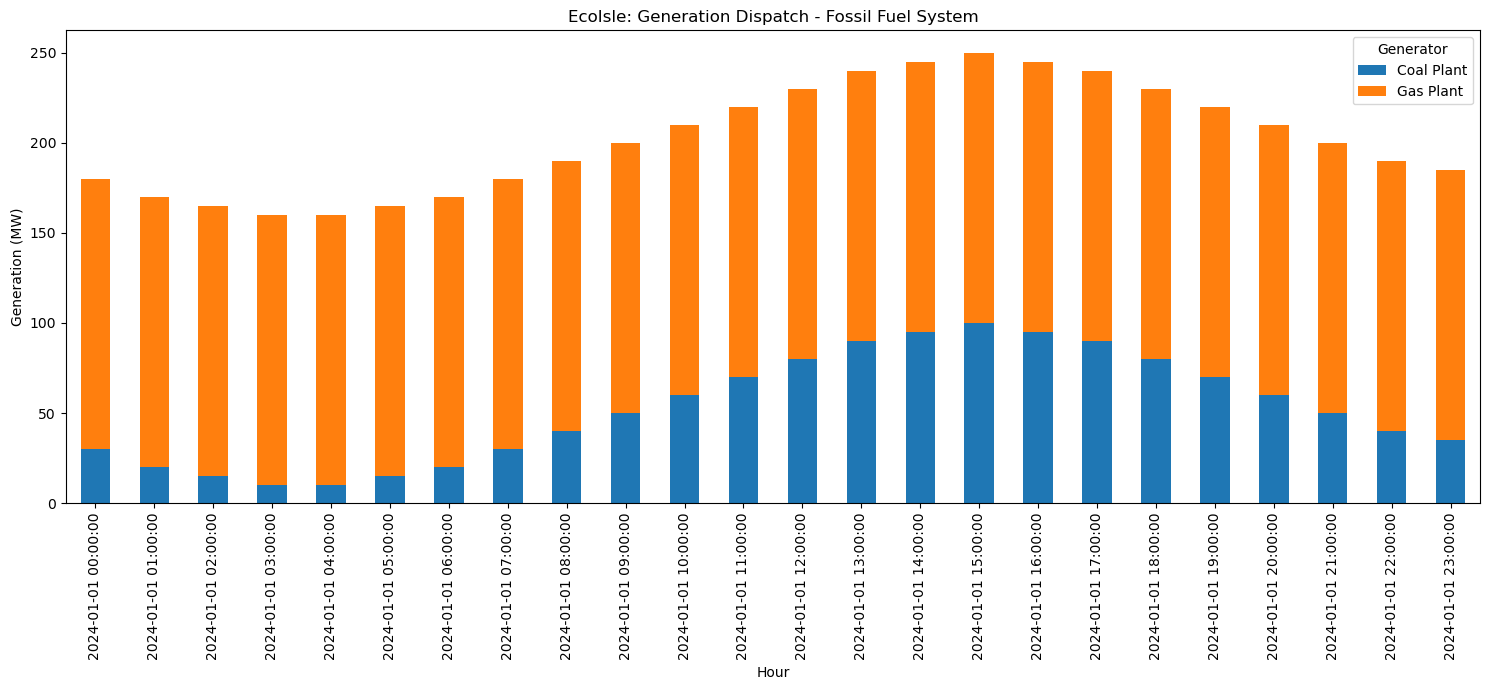

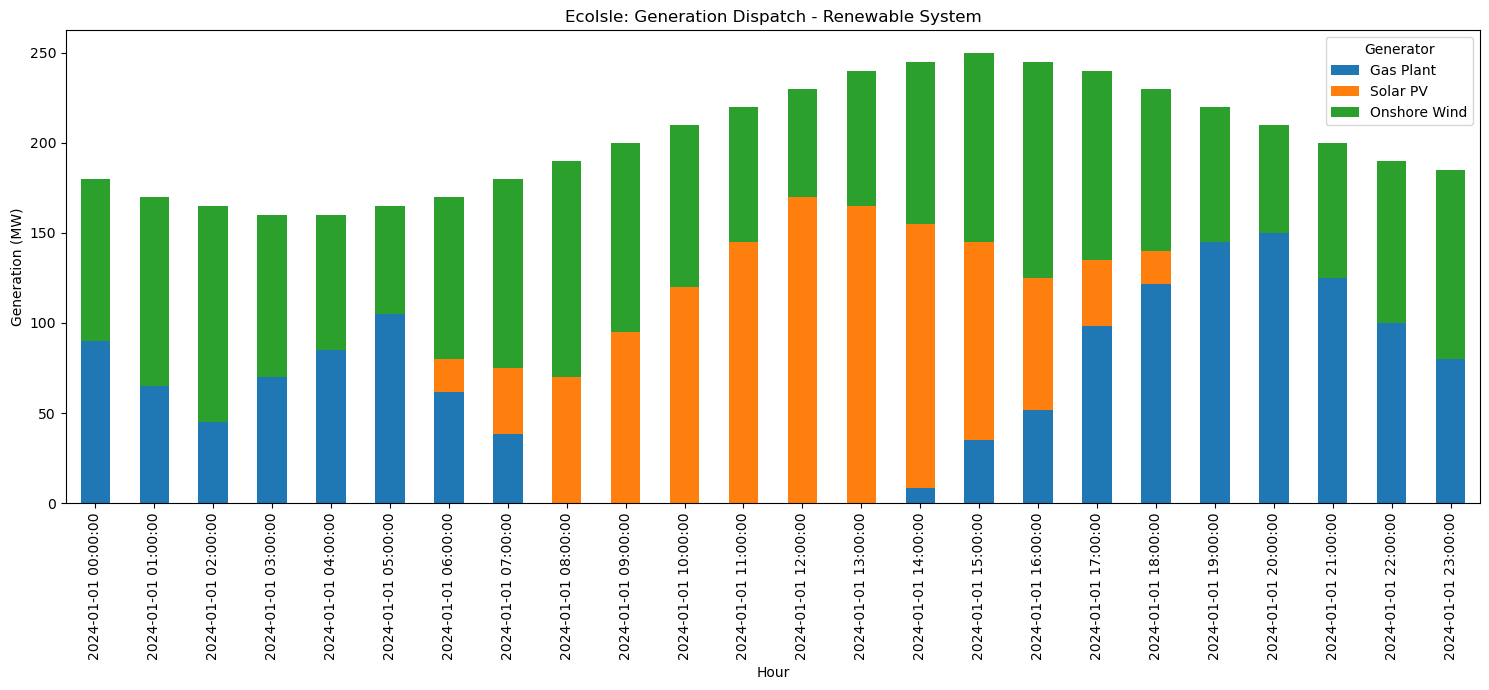

In [18]:
def plot_generation_dispatch(network, title):
    gen_dispatch = network.generators_t.p
    gen_dispatch.plot(kind='bar', stacked=True, figsize=(15, 7))
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Generation (MW)")
    plt.legend(title="Generator")
    plt.tight_layout()
    plt.show()

print("\nPlotting generation dispatch for both systems...")

plot_generation_dispatch(network_old, 
    "EcoIsle: Generation Dispatch - Fossil Fuel System")
plot_generation_dispatch(network_new, 
    "EcoIsle: Generation Dispatch - Renewable System")

### PART 5: Key Modeling Notes (for reference)

- PyPSA annualizes CAPEX based on default lifetime (20y) and discount rate (7%).

- Investment optimization via p_nom_extendable=True and capital_cost.

- OPEX = sum of all generator dispatch * marginal cost, over all hours.

- Emission calculation uses per-generator emission factors.

- Further experiments: fix solar capacity, vary load/gas cost, etc.

#### End of EcoIsle Case Study Script